# PCA by Hand und mit Sklearn (DE)

In [26]:
import numpy as np                       # mathematical methods
from scipy import stats                  # statistical methods
import pandas as pd                      # handle named data frames
from matplotlib import pyplot as plt     # plotting methods
from scipy import stats                  # statistic methods
from sklearn.decomposition import PCA    # our new working horse
from mpl_toolkits.mplot3d import Axes3D  # if 3D plots...

%matplotlib notebook

## Grundfragen: Kovarianz

### Wie ändern sich die Eigenwerte und Eigenvektoren einer Kovarianzmatrix wenn Sie in dem zugrundeliegenden Datensatz zwei Einträge austauschen?
$ \color{red}{\textbf{Antwort:}}$

Es gilt für die Kovarianzmatrix C

$\mathbf{C} = \frac{1}{n-1}\mathbf{AA}^T$

wobei A die Matrix der zentrierten Daten für alle Einträge sind (Zeilen: Variablen, Spalten: Einträge). Jeder Matrixwert von C ergibt sich somit aus der Multiplikation zweier Zeilen von A. Das Austauschen zweier Einträge bedeutet das vertauschen zweier Spalten und somit zweier Werte innerhalb jeder Zeile. Bei der Multiplikation zweier Zeilen werden dann aber nach wie vor dieselben Werte miteinander multipliziert und dann aufaddiert. Somit ändert sich C nicht, folglich auch nicht ihre Eigenwerte und Eigenvektoren.


### Wie ändern sich Eigenwerten und Eigenvektoren einer Kovarianzmatrix wenn Sie den zugrundeliegenden Datensatz mit einem Faktor $\beta$ skalieren (zB. $10^{-3}$ alle Gewichte in kg statt g angeben)?
$ \color{red}{\textbf{Antwort:}}$

$\mathbf{C_{skaliert}} = \frac{1}{m-1}\beta\mathbf{A}(\beta\mathbf{A})^T
= \beta^2\frac{1}{m-1}\mathbf{A}\mathbf{A}^T
= \beta^2\mathbf{C}$

Die Eigenwerte werden also um den Faktor $\beta^2$ skaliert, die Eigenvektoren bleiben gleich.

### Wie ändern sich Eigenwerten und Eigenvektoren einer Kovarianzmatrix wenn Sie in dem zugrundeliegenden Datensatz zwei Variablen (zB. Körpergewicht und Schlafdauer) austauschen?

$ \color{red}{\textbf{Antwort:}}$

Wenn wir die Reihenfolge zwei Variablen in einem Matrix wechseln, verändern die Verteilungen der Daten und die Zusammenhängen der Daten miteinader nicht. Daher die Eigenwerte bleiben dieselbe, aber die Reihenfolge aber nicht die Größe der Items in einem Eigenvektor wird geändert. 


## PCA by Hand
### Aufgabe: mit den Buchstaben Bildern X-T-L (3x3 pixels Bilder) arbeiten

In [27]:
# Environment Setting

import numpy as np                       # mathematical methods
from scipy import stats                  # statistical methods
import pandas as pd                      # handle named data frames
from matplotlib import pyplot as plt     # plotting methods
from scipy import stats                  # statistic methods
from sklearn.decomposition import PCA    # our new working horse
from mpl_toolkits.mplot3d import Axes3D  # if 3D plots...

%matplotlib notebook

In [28]:
plt.rcParams['image.cmap'] = 'gray'                # no colors, just gray values
plt.rcParams['image.interpolation'] = 'nearest'    # simulate pixel areas

def plotimages(data, crange):
    '''conveniently plot 4 images of 3 types in a matrix fashion
       input: data matrix of 30 images with 9 pixels each
              range of values to be plotted: 0..255 for ordinary images, -127..127 for diffs
       output: the graph 3 lines with images from categories, 4 pcs each, and a value bar
    '''
    fig = plt.figure(figsize=(9, 6))
    for i, j in enumerate([1, 2, 3, 4, -1, 11, 12, 13, 14, -1, 21, 22, 23, 24, -1]):
        fig.add_subplot(3, 5, i+1)
        image = data[:,j].reshape((3, 3))                  # 9 pixel as 3x3 2D-image
        plt.xticks([])                                     # no pixelnumbers
        plt.yticks([])
        plt.imshow(image, vmin=crange[0], vmax=crange[1])  # plus/minus range
        if j<0:                                            # no image 
            plt.gca().set_visible(False)               
            plt.colorbar();

<IPython.core.display.Javascript object>


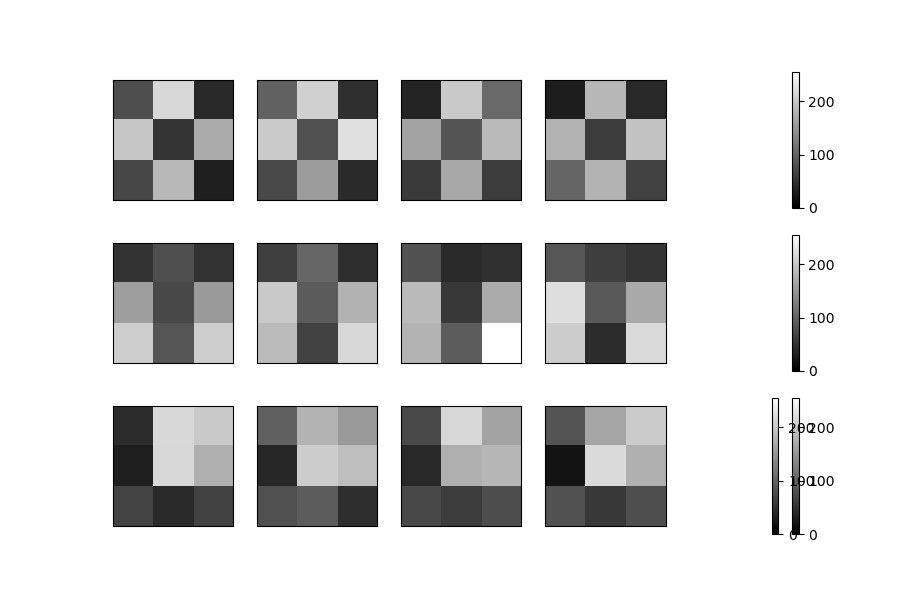

In [29]:
# Images erstellen

np.random.seed(987654321)
vshape = (3, 3)                # a 3x3 pixel image
vn = vshape[0]*vshape[1]       # total number of pixels: 9
v = np.zeros((vn, 3*10))       # reserve space for 3x10 images a 3x3
for i in range(0, 10):         # "X"   (leave head room for added noise)
    v[:, i] = 192-np.array([1, 0, 1, 0, 1, 0, 1, 0, 1])*128+20*stats.norm.rvs(size=vn)
for i in range(10, 20):        # "T"
    v[:, i] = 192-np.array([1, 1, 1, 0, 1, 0, 0, 1, 0])*128+20*stats.norm.rvs(size=vn)
for i in range(20, 30):        # "L"
    v[:, i] = 192-np.array([1, 0, 0, 1, 0, 0, 1, 1, 1])*128+20*stats.norm.rvs(size=vn)
plotimages(v, (0, 255))        # show the data as gray scale 3x3 images

$ \color{red}{\textbf{Schritt 1: Mittelwertmatrix}}$

In [30]:
# Mittelwert Matrix

vmean = v.mean(axis=1)               # average all pixels over images
print(np.shape(vmean))
image = vmean.reshape(vshape)        # break in 3 lines a 3 pixels
plt.imshow(image, vmin=0, vmax=255)  # show data as image, gray values within 0..255
plt.xticks([0, 1, 2])                # neither x
plt.yticks([0, 1, 2])                # nor y ticks
plt.colorbar();                      # but brightness gray values
print(np.round(vmean, decimals=2))   # show data numerically as well


(9,)
[ 68.89 151.7  102.18 146.05 111.2  189.63 110.75 103.5  111.14]


<IPython.core.display.Javascript object>


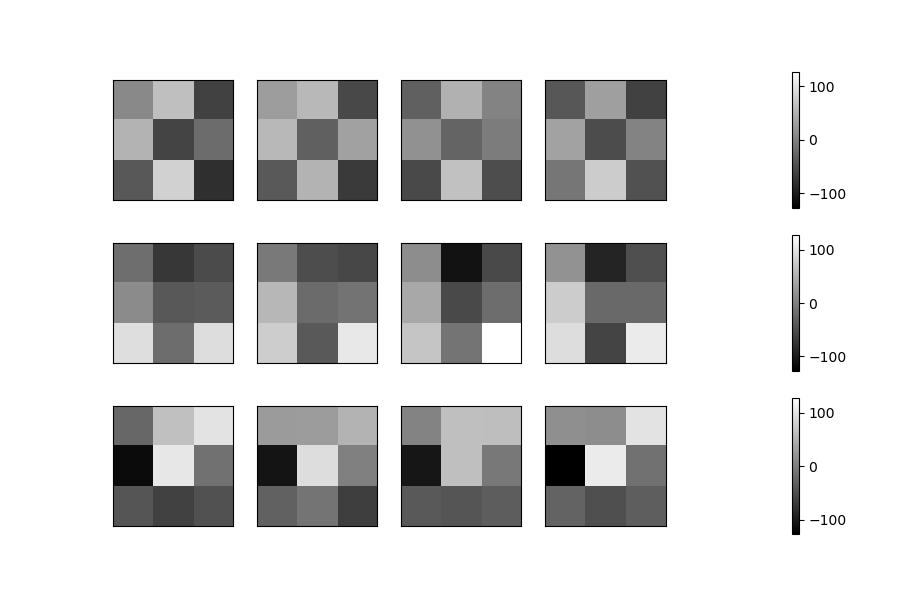

In [31]:
# deviations

a = (v.T - vmean).T
plotimages(data=a, crange=(-127, 127))        # color range plus and minus

$ \color{red}{\textbf{Schritt 2: Kovarianzmatrix}}$

In [32]:
#covariance matrix

print('data Matrix A has shape {}'.format(a.shape))
C = 1./a.shape[1] * np.dot(a, a.T)
print('covariance matrix C has shape {}'.format(C.shape))
print(np.round(C, decimals=0))

data Matrix A has shape (9, 30)
covariance matrix C has shape (9, 9)
[[  484.   136.   256.  -259.   372.   -18.   -40.  -272.    54.]
 [  136.  4265.  1946. -2403.  1823.   -30. -3121.  1465. -3712.]
 [  256.  1946.  4162. -4286.  3839.  -263. -1510. -2090. -1497.]
 [ -259. -2403. -4286.  5519. -4406.   278.  2007.  2000.  1881.]
 [  372.  1823.  3839. -4406.  4128.  -334. -1405. -2259. -1428.]
 [  -18.   -30.  -263.   278.  -334.   348.   -70.   234.   -39.]
 [  -40. -3121. -1510.  2007. -1405.   -70.  2990. -1423.  3222.]
 [ -272.  1465. -2090.  2000. -2259.   234. -1423.  3622. -1848.]
 [   54. -3712. -1497.  1881. -1428.   -39.  3222. -1848.  4297.]]


In [33]:
# Check demensions

num_data, dimC = C.shape
print(format('Covariacne matrix C has demension level of {}'.format(dimC)))

Covariacne matrix C has demension level of 9


Kovarianzmatrix C hat 9 Dimensionen. Die Dimensionen sind wie derer Datamatrix selbst. Weil:

$ C = \frac{1}{n-1} A  A^{\mathrm{T}}$

Der Rang der Matrix $A$ ist 9, der Rang des Produktes von Matrix A und deren transponierten Matrix $A^{\mathrm{T}}$ ist dann auch 9.

$ \color{red}{\textbf{Schritt 3: Diagonalisierung}}$

In [34]:
# Eigenvalues and Eigenvectors calculation
EW, EV = np.linalg.eig(C)

In [35]:
'''test if really Eigenvalue / -vectors
   rem: rank of C is not #images but #pixels (usually the other way round...)'''
for i in range(min(v.shape[0], v.shape[1])-1):
    np.testing.assert_allclose(np.dot(C, EV.T[i]), EW[i]*EV.T[i])
# no exception means: they are (very close to) zero

Eigenvalues:
[17439.  9630.   688.   610.   115.   194.   304.   443.   391.]


<IPython.core.display.Javascript object>


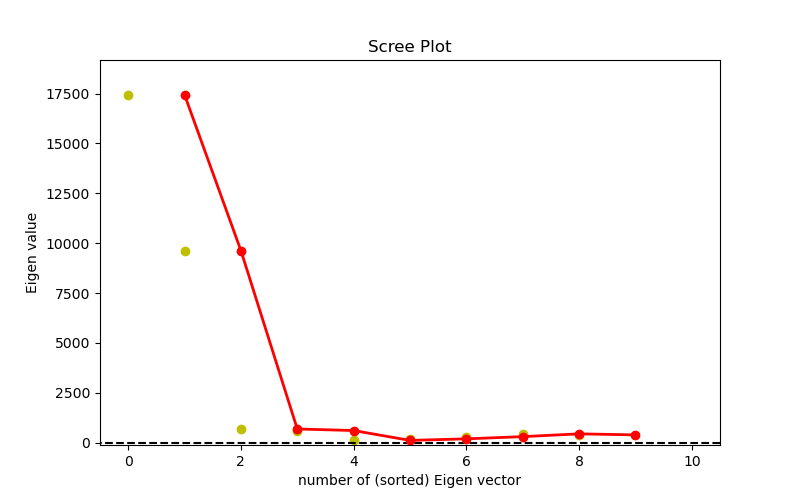

In [36]:
print('Eigenvalues:')
print(np.round(EW, decimals=0))
plt.figure(figsize=(8,5))
plt.plot(EW, 'yo')
plt.plot([-1,12], 2*[0], 'k--')
plt.xlabel('number of (sorted) Eigen vector')
plt.ylabel('Eigen value')
plt.axis((-.5, 10.5, -min(EW), 1.1*max(EW)));
sing_vals=np.arange(len(EW)) + 1
plt.plot(sing_vals,EW, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.show() 

$ \color{red}{\textbf{Schritt4: Entscheidung}}$

[58.49156465 32.29934398  2.30700318  2.04603103  0.38667836  0.64958706
  1.01959753  1.48735506  1.31283917]


<IPython.core.display.Javascript object>


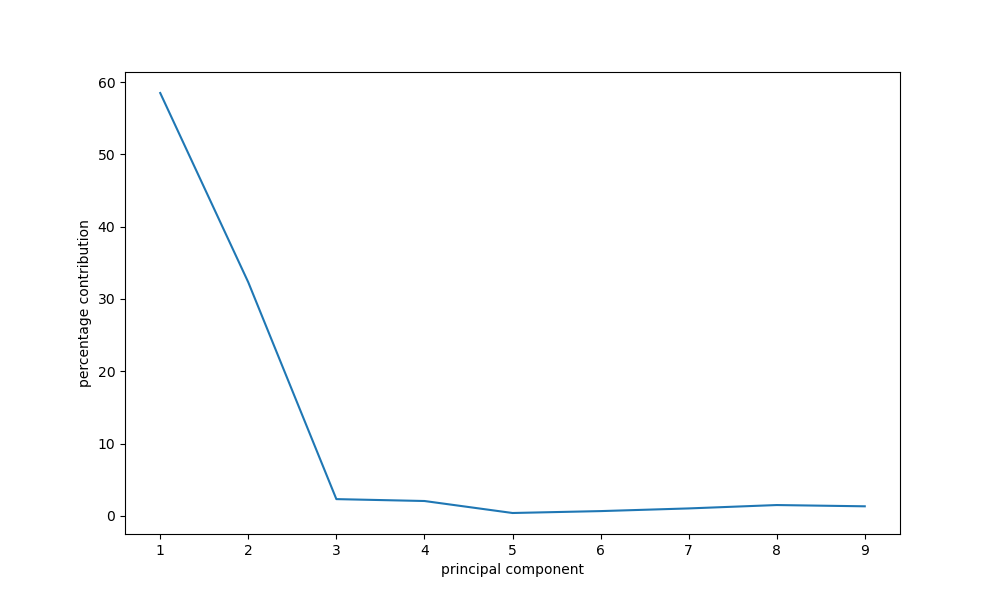

Text(0, 0.5, 'percentage contribution')

In [37]:
# Prop is the contribution propotion of each eigenvalue
prop = EW/EW.sum()
contribution= [EW,prop]
print(prop*100)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]


'''show percentage contribution of each eigenvalue'''
plt.figure(figsize=(10,6))
plt.plot(x,prop*100, ls='-',  label='X')     # the Xs

plt.xlabel('principal component')
plt.ylabel('percentage contribution')


### Welche Eigenwerte erhalten Sie? Wo würden Sie passenderweise abschneiden?

Eigenwert:
[14774.  7908.   299.   234.   245.   145.    35.    62.    87.]

Von den Scree Plot sieht man, dass bei PC3 gibt es einen auffälligen Wendepunkt. Daher sind die meisten Informationen des Datensatzes in den ersten zwei PC beinhaltet.(Anschaulich kann man auch von der Prozentzahl der erklärter Varianz durch den Hauptkomponenten dieselbe Ergebnisse bekommen.)

Die einzelnen Vektoren von den behaltenen Eigenvektoren sind die Hauptkomponenten.

In [38]:
for i in range(2):
    print('Eigenwert',np.round(EW[i],2),': passender Eigenvektor:\n',np.round(EV[:,i].T,2),'\n')

Eigenwert 17439.37 : passender Eigenvektor:
 [-0.03 -0.38 -0.44  0.51 -0.43  0.02  0.31  0.1   0.34] 

Eigenwert 9630.11 : passender Eigenvektor:
 [-0.04  0.38 -0.24  0.23 -0.27  0.04 -0.34  0.58 -0.45] 



$ \color{red}{\textbf{Schritt 5: Passende Projektionsmatrix W}}$

In [39]:
# create sub space K

liste = [(np.abs(EW[i]), EV[:, i]) for i in range(EW.shape[0])]
liste.sort()                                    # Sort Eigenvalues
liste.reverse()                                 # biggest to shortest
h = 2                                           # number of wanted components
W = np.asarray([liste[i][1] for i in range(h)]) # Matrix W of EVs u_i
print('matrix U of first h={} Eigen-vectors has shape {}'.format(h, W.shape))
W

matrix U of first h=2 Eigen-vectors has shape (2, 9)


array([[-0.02813173, -0.37525256, -0.43508599,  0.51412547, -0.4331054 ,
         0.02349313,  0.30586986,  0.0955713 ,  0.33756013],
       [-0.03731116,  0.38453582, -0.24463437,  0.23444346, -0.27039651,
         0.04168273, -0.341862  ,  0.58228148, -0.45294294]])

$ \color{red}{\textbf{Schritt 6: Angeben die Projektion des ersten Bildes in den Unterraum}}$

[[-0.03 -0.38 -0.44  0.51 -0.43  0.02  0.31  0.1   0.34]
 [-0.04  0.38 -0.24  0.23 -0.27  0.04 -0.34  0.58 -0.45]]
(2, 9)
Projection of image v[0] onto 2-dim sub space U' has components
[ 72.   106.02]


<IPython.core.display.Javascript object>


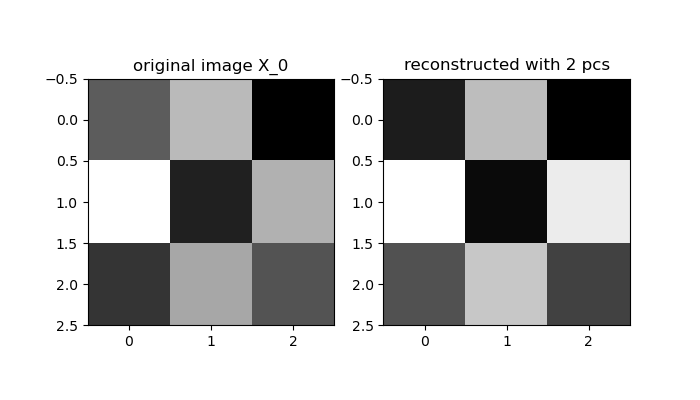

(9,)


array([ 62.90730855, 165.45119278,  44.91797287, 207.91736699,
        51.35323921, 195.73765616,  96.52454252, 172.11934176,
        87.42327285])

In [40]:
# define sub space of first h=2 principal components
h = 2                                 # restrict sub space to 2 principal components
Wprime = W[:h]                        # select first vectors spanning the sub space
print(np.round(Wprime, decimals=2))
print(Wprime.shape)


# project an example image a onto sub space W-prime
ao = v[:, 0] - vmean                  # a in original variable space 
alpha = Wprime.dot(ao)                # transformed a in u_i  i=0..4
print("Projection of image v[0] onto {}-dim sub space U' has components\n{}"
      .format(Wprime.shape[0], np.round(alpha, decimals=2)))

# compare original image with reconstructed
vX0 = v[:,0]                            # choose 1st image (index 0), full vector (:)
aX0 = vX0 - vmean                       # the centralized image "burlesque"
v_0 = vmean.copy()                      # start with the average
for u in W:                             # cycle through the (sorted) Eigenvectors
    v_0 += np.dot(u, aX0) * u           # add up next re-projection of principal component
fig = plt.figure(figsize=(7,4))
fig.add_subplot(1, 2, 1)
image = vX0.reshape(vshape)             # original (3 lines a 3 pixels)
plt.title('original image X_0')
plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest');
fig.add_subplot(1, 2, 2)
image = v_0.reshape(vshape)             # reconstructed
plt.title('reconstructed with {} pcs'.format(h))
plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest');

print(v_0.shape)
v_0

In [41]:
Wprime

array([[-0.02813173, -0.37525256, -0.43508599,  0.51412547, -0.4331054 ,
         0.02349313,  0.30586986,  0.0955713 ,  0.33756013],
       [-0.03731116,  0.38453582, -0.24463437,  0.23444346, -0.27039651,
         0.04168273, -0.341862  ,  0.58228148, -0.45294294]])

$ \color{red}{\textbf{Projizierung aller Daten}}$

In [42]:
# transform all n=30 images into sub space U
Alpha = Wprime.dot((v.T-vmean).T)        # strange 2x transposed because of subtracting mean
print('All images projected onto PCs: Alpha, which has shape {}'.format(Alpha.shape))
print(Alpha)

All images projected onto PCs: Alpha, which has shape (2, 30)
[[  71.99587341   23.30239785   15.1872504   -25.27435859   45.06035632
    36.10864642   56.4287652    17.35826177   27.29169502   40.81785185
   126.44936464  130.45210254  134.73379834  175.89878593  160.91369054
   162.56340822  109.87424458  138.17743555  143.25542192  139.11947522
  -178.88077958 -204.90715685 -161.06263292 -159.6406291  -184.83134389
  -154.86294063 -156.2550595  -172.25924873 -194.58100016 -162.43367577]
 [ 106.02118896  162.81166391  130.67477285  108.68919622  119.00359791
   151.81832555  148.5945172   152.93722297  123.38035593  131.79162316
   -60.80588688  -87.87559133  -82.53731271 -101.35044387 -114.91586354
   -54.6394209  -115.61500731  -73.85635041 -101.08034967  -72.97242533
   -62.59165592  -54.11304166  -19.66742224  -29.16136206  -82.01798509
   -53.76746557  -88.2374031   -13.11509363  -35.17479859  -32.22758482]]


$ \color{red}{\textbf{Graphiken Erstellung; Anteile aller Hauptkomponenten an jedem Pixel}}$

<IPython.core.display.Javascript object>


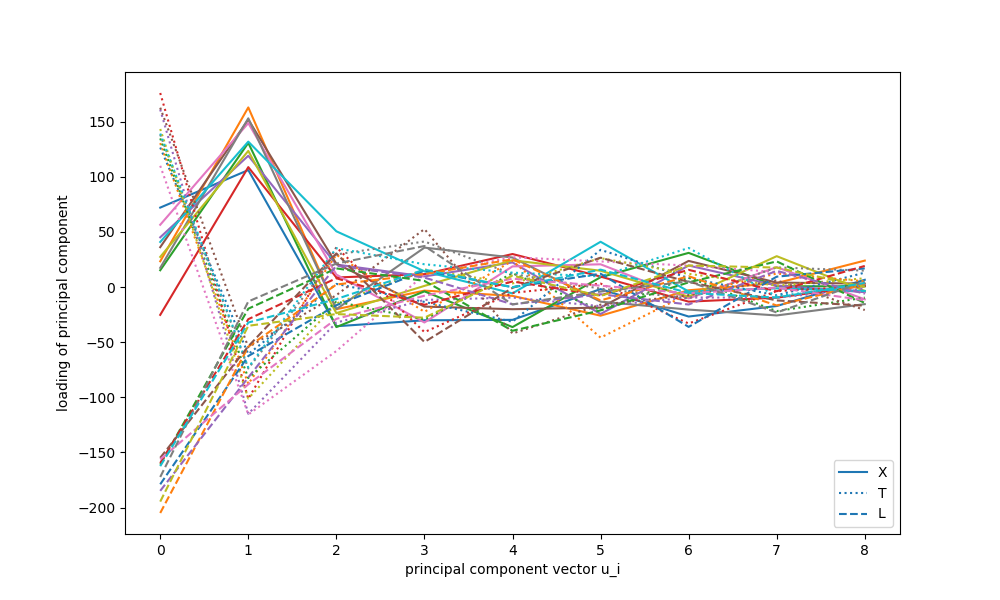

In [43]:
# create sub space K
liste = [(np.abs(EW[i]), EV[:, i]) for i in range(EW.shape[0])]
liste.sort()                                    # Sort Eigenvalues
liste.reverse()                                 # biggest to shortest
h = 9                                           # number of wanted components
W = np.asarray([liste[i][1] for i in range(h)]) # Matrix U of EVs u_i
Wprime = W[:h]                        # select first vectors spanning the sub space
ao = v[:, 0] - vmean                  # a in original variable space 
alpha = Wprime.dot(ao)                # transformed a in u_i  i=0..8
Alpha = Wprime.dot((v.T-vmean).T)        # strange 2x transposed because of subtracting mean

# show distribution of components within images
plt.figure(figsize=(10,6))

plt.plot(Alpha[:, 0:10], ls='-',  label='X')     # the Xs
plt.plot(Alpha[:,10:20], ls=':',  label='T')     # the Ts
plt.plot(Alpha[:,20:30], ls='--', label='L')     # the Ls

   
plt.xlabel('principal component vector u_i')
plt.ylabel('loading of principal component')     
        

plt.xticks([0, 1, 2, 3, 4,5,6,7,8])
handles, labels = plt.gca().get_legend_handles_labels()  # fetch axes object and legend entries therein
handles = handles[::10]                                  # only every 10th 
labels = labels[::10]
plt.legend(handles, labels, loc='lower right');

## PCA mit Skleran

In [44]:
from sklearn.decomposition import PCA


# If not clear, how many components will be remained: 
v_pca = PCA().fit(v.T)
print(v_pca.components_)
print("\n Data with all component has the shape:{}\n".format(v_pca.components_.shape))

# If just two components, which can contain the most information of the original data:
v_pca2 = PCA(n_components=2)
v_pca2.fit(v.T)
print(v_pca2.components_)
print("\n Data with all component has the shape:{}".format(v_pca2.components_.shape))

[[ 0.02813173  0.37525256  0.43508599 -0.51412547  0.4331054  -0.02349313
  -0.30586986 -0.0955713  -0.33756013]
 [-0.03731116  0.38453582 -0.24463437  0.23444346 -0.27039651  0.04168273
  -0.341862    0.58228148 -0.45294294]
 [ 0.34370764  0.39636288  0.20376881  0.66423362  0.15666274 -0.08839666
   0.23198417 -0.34934014 -0.18390522]
 [-0.43099897 -0.54351744  0.16396597  0.23575171  0.04887627  0.04917988
  -0.05325472 -0.19340643 -0.625552  ]
 [ 0.69779749 -0.37734307 -0.39617217 -0.04837802  0.26782062  0.14642809
  -0.27253818 -0.05627414 -0.20195331]
 [-0.13488856  0.08490088 -0.49320705 -0.17714818  0.28161119 -0.63323139
   0.39927091  0.01957907 -0.24469325]
 [ 0.19886092 -0.30432246  0.42853954  0.17648244  0.03263182 -0.65575063
  -0.24148827  0.37009599  0.16336656]
 [ 0.35314177 -0.11485323  0.31159834 -0.26812731 -0.28968039  0.140965
   0.62454374  0.30822398 -0.32291033]
 [ 0.15668568  0.05834035 -0.03876069 -0.21717708 -0.69018912 -0.33937411
  -0.22551164 -0.5068003

In [45]:
# Projektion des ersten Bildes in den Unterraum
alpha = v_pca2.transform(v[:, 0].reshape(1, -1))  
print(alpha)
print(alpha.shape)


[[-71.99587341 106.02118896]]
(1, 2)


In [46]:
# Projektion aller Daten
Alpha_v = v_pca2.transform(v.T)
print(Alpha_v)
print(Alpha_v.shape)

[[ -71.99587341  106.02118896]
 [ -23.30239785  162.81166391]
 [ -15.1872504   130.67477285]
 [  25.27435859  108.68919622]
 [ -45.06035632  119.00359791]
 [ -36.10864642  151.81832555]
 [ -56.4287652   148.5945172 ]
 [ -17.35826177  152.93722297]
 [ -27.29169502  123.38035593]
 [ -40.81785185  131.79162316]
 [-126.44936464  -60.80588688]
 [-130.45210254  -87.87559133]
 [-134.73379834  -82.53731271]
 [-175.89878593 -101.35044387]
 [-160.91369054 -114.91586354]
 [-162.56340822  -54.6394209 ]
 [-109.87424458 -115.61500731]
 [-138.17743555  -73.85635041]
 [-143.25542192 -101.08034967]
 [-139.11947522  -72.97242533]
 [ 178.88077958  -62.59165592]
 [ 204.90715685  -54.11304166]
 [ 161.06263292  -19.66742224]
 [ 159.6406291   -29.16136206]
 [ 184.83134389  -82.01798509]
 [ 154.86294063  -53.76746557]
 [ 156.2550595   -88.2374031 ]
 [ 172.25924873  -13.11509363]
 [ 194.58100016  -35.17479859]
 [ 162.43367577  -32.22758482]]
(30, 2)


[[-0.03 -0.38 -0.44  0.51 -0.43  0.02  0.31  0.1   0.34]
 [-0.04  0.38 -0.24  0.23 -0.27  0.04 -0.34  0.58 -0.45]]
(2, 9)


<IPython.core.display.Javascript object>


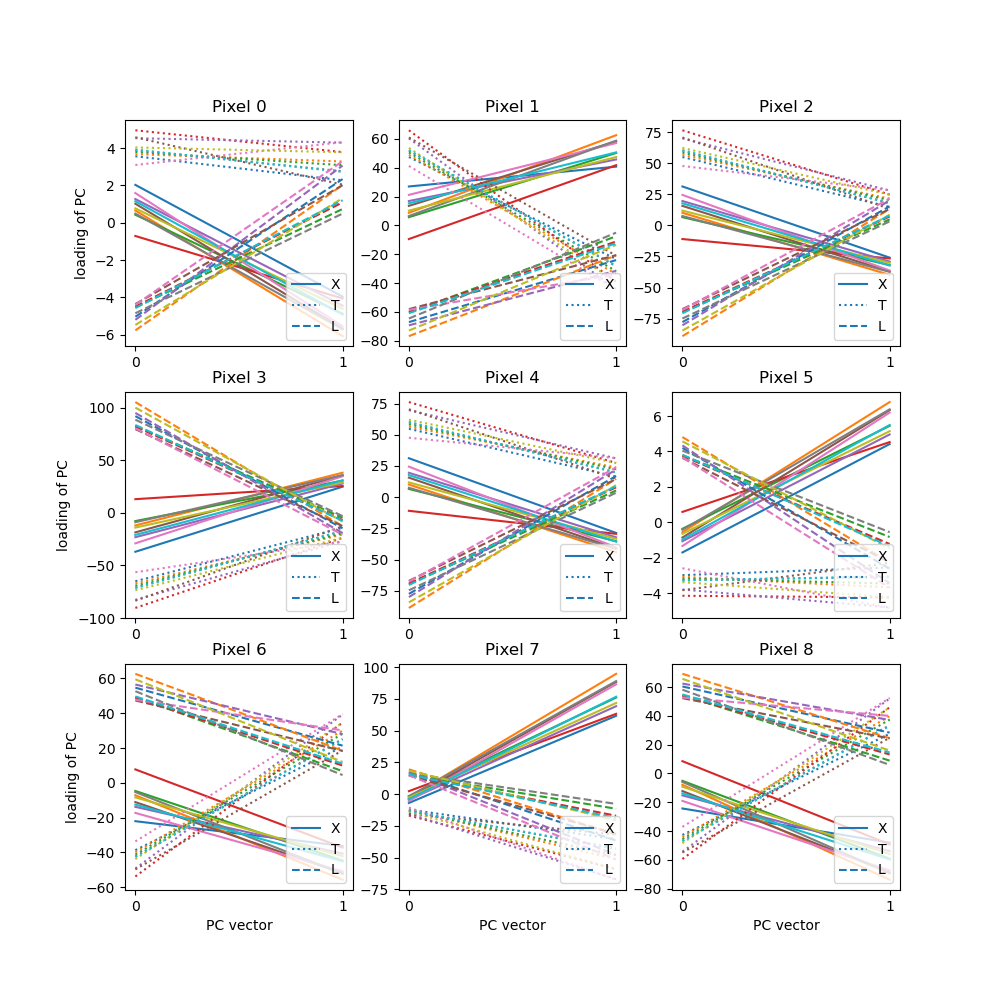

In [47]:
# Graphik der Anteile aller Hauptkomponenten an jedem Pixel

# redefine sub space of first h=2 principal components
h = 2                                 # restrict sub space to 2 principal components
Wprime = W[:h]                        # select first vectors spanning the sub space
print(np.round(Wprime, decimals=2))
print(Wprime.shape)

'''show distribution of components within images'''          
Alpha = Alpha.T            

fig = plt.figure(figsize=(10, 10))

for i in range(len(W[0])):
    
    fig.add_subplot(3, 3, i+1)
    
    plt.plot(Alpha_v.T[:,0:10] * Wprime[:,i:(i+1)], ls='-',  label='X')     # the Xs
    plt.plot(Alpha_v.T[:,10:20] * Wprime[:,i:(i+1)], ls=':',  label='T')     # the Ts
    plt.plot(Alpha_v.T[:,20:30] * Wprime[:,i:(i+1)], ls='--', label='L')     # the Ls
    
    plt.title('Pixel {}'.format(i))
    if (i > 5): # only left subplots
        plt.xlabel('PC vector')
    if (i % 3 == 0): # only bottom subplots
        plt.ylabel('loading of PC')
               
    plt.xticks([0, 1])
    handles, labels = plt.gca().get_legend_handles_labels()  # fetch axes object and legend entries therein
    handles = handles[::10]                                  # only every 10th 
    labels = labels[::10]
    plt.legend(handles, labels, loc='lower right');

<IPython.core.display.Javascript object>


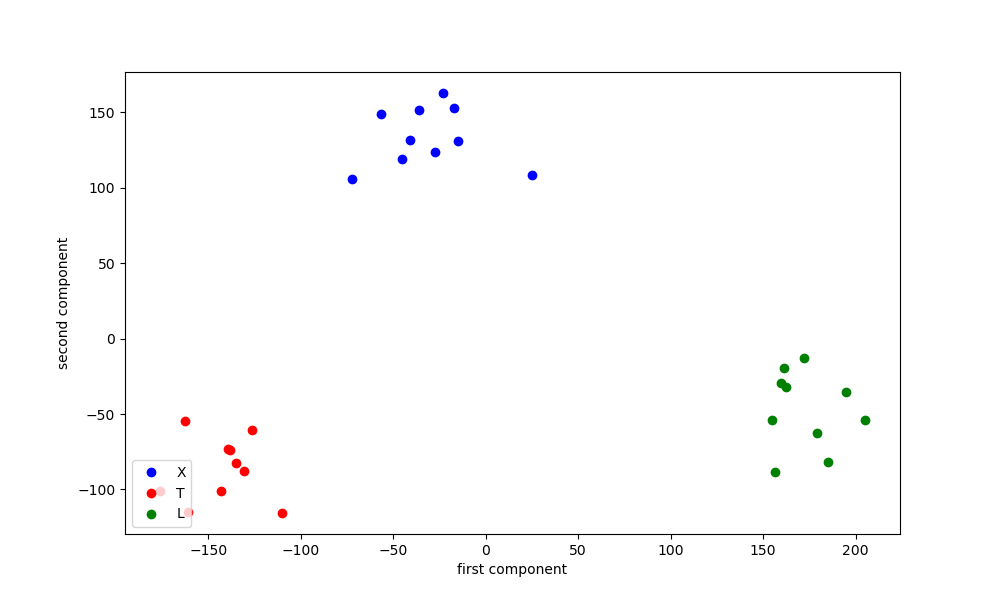

In [48]:
# Anteile an der ersten vs. Anteile an der zweiten Hauptkomponente

'''separation according to loading of first two principal components'''
plt.figure(figsize=(10,6))
plt.plot(Alpha_v.T[0, 0:10], Alpha_v.T[1, 0:10], 'bo', label='X')
plt.plot(Alpha_v.T[0,10:20], Alpha_v.T[1,10:20], 'ro', label='T')
plt.plot(Alpha_v.T[0,20:30], Alpha_v.T[1,20:30], 'go', label='L')
plt.xlabel('first component')
plt.ylabel('second component')
plt.legend(loc='lower left');

In [55]:
Alpha_v.T.shape


(2, 30)

<IPython.core.display.Javascript object>


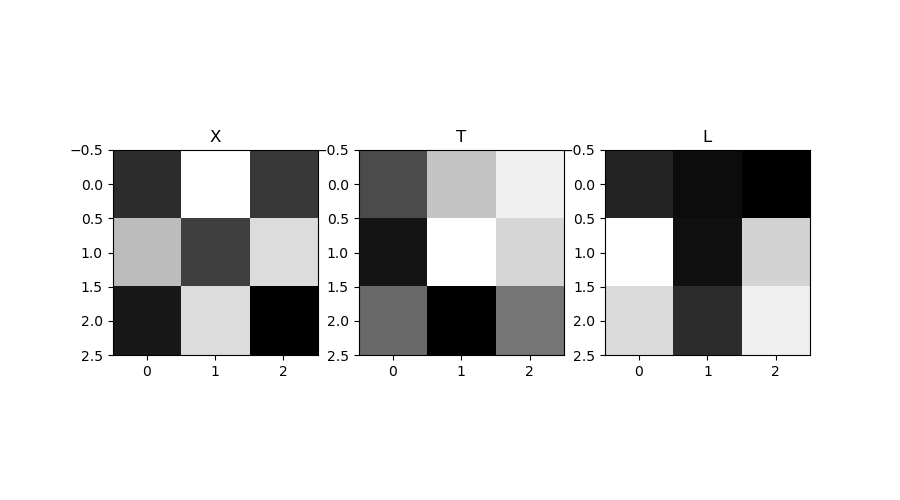

In [56]:
# Rücktransformation auf die ursprünglichen Variabeln.
# REM: den Mittelwert zurück addieren

'''reconstruct'''
fig = plt.figure(figsize=(9,5))

fig.add_subplot(1, 3, 1)
v_r = vmean + Alpha_v.T[:, 1].dot(Wprime)
image = v_r.reshape(vshape)             # original (3 lines a 3 pixels)
plt.title('X')
plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest');

fig.add_subplot(1, 3, 2)
v_r = vmean + Alpha_v.T[:, 14].dot(Wprime)
image = v_r.reshape(vshape)             # original (3 lines a 3 pixels)
plt.title('T')
plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest');

fig.add_subplot(1, 3, 3)
v_r = vmean + Alpha_v.T[:, 24].dot(Wprime)
image = v_r.reshape(vshape)             # original (3 lines a 3 pixels)
plt.title('L')
plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest');

Not understanable... Image indexing 14(the 15th image)should be a "L" image, indexing 24 (25th image) is a "T" image. But they change with each other...